In [273]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:

def aggregate_market_data():
    """
    Aggregates market data for all tickers within a specified period.

    Args:
        period_start (date): The start date for data aggregation.
        period_end (date): The end date for data aggregation.

    Returns:
        None: Writes the aggregated data to CSV files.
    """
    all_paths = os.listdir('data')
    all_df = []
    for ticker in tqdm(all_paths):
        try:
            mkt_data_ticker = pd.read_csv(os.path.join('data',ticker),index_col=0)
            mkt_data_ticker.columns = [ticker.replace('.csv',"")]
            all_df.append(mkt_data_ticker)
        except:
            print("failed {0}".format(ticker))
    return all_df
data = aggregate_market_data()
df = pd.concat(data,axis=1).dropna(axis=1, how='any').pct_change().dropna()
df.index = pd.to_datetime(df.index)
df = df.sort_index().loc['2015':]
sc = StandardScaler()
df = pd.DataFrame(sc.fit_transform(df),index = df.index,columns = df.columns)
df = pd.DataFrame(df.stack(),columns = ['Ret'])
df.index.names =['date','Ticker']
df_orig = df.copy()
start_year = "2020"
df.loc[start_year:] = np.nan
df = df.swaplevel(0, 1)
df_orig = df_orig.swaplevel(0, 1)

100%|██████████| 141/141 [00:00<00:00, 242.94it/s]


In [275]:
df = df['Ret'].unstack().T


In [276]:
start_date = df.index.min()
end_date = df.index.max()
new_index = pd.date_range(start_date, end_date, freq='B')
df_reindexed = df.reindex(new_index)
df_reindexed.index.names = ['date']
df_reindexed

Ticker          AAPL       ABT      ADBE       ADI       ADM       ADP  \
date                                                                     
2015-01-02 -0.572692 -0.212964 -0.291391 -0.025651 -0.002244 -0.103795   
2015-01-05 -1.575902 -0.025001 -0.292576 -0.954233 -2.130621 -0.088443   
2015-01-06 -0.056119 -0.778368 -1.021796 -1.219026 -1.224740 -0.572716   
2015-01-07  0.693089  0.487948  0.342029  0.482892  0.888750  0.515597   
2015-01-08  2.004911  1.297807  1.167007  0.840247 -0.914323  1.425129   
...              ...       ...       ...       ...       ...       ...   
2023-06-26       NaN       NaN       NaN       NaN       NaN       NaN   
2023-06-27       NaN       NaN       NaN       NaN       NaN       NaN   
2023-06-28       NaN       NaN       NaN       NaN       NaN       NaN   
2023-06-29       NaN       NaN       NaN       NaN       NaN       NaN   
2023-06-30       NaN       NaN       NaN       NaN       NaN       NaN   

Ticker          ADSK       AEE       AEP       AIG  ...       CPB       CSX  \
date                                                ...                       
2015-01-02 -0.406605 -0.249338  0.502895  0.067438  ... -0.016487 -0.602602   
2015-01-05 -0.649773 -0.742361 -1.133019 -0.940691  ... -1.001796 -1.494338   
2015-01-06 -0.866504 -0.858256  0.382598 -0.678777  ... -0.449640 -2.182673   
2015-01-07 -0.123641  0.515842  1.036754  0.208142  ...  2.840175  0.668101   
2015-01-08  1.003346  0.215381  0.618868 -0.221934  ...  1.291348  0.817373   
...              ...       ...       ...       ...  ...       ...       ...   
2023-06-26       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2023-06-27       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2023-06-28       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2023-06-29       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2023-06-30       NaN       NaN       NaN       NaN  ...       NaN       NaN   

Ticker          CTAS       CVX         D        DD       DDS        DE  \
date                                                                     
2015-01-02 -0.054060  0.156278  0.528081 -0.040849 -0.735000 -0.127383   
2015-01-05 -1.132757 -2.077468 -0.849389 -1.576820 -0.185639 -1.167114   
2015-01-06 -0.176048 -0.050468 -0.359810 -0.828378 -0.673126 -0.485351   
2015-01-07 -0.371171 -0.069388  0.277508 -0.099929  0.996282 -0.275881   
2015-01-08  0.910605  1.147320  0.813122  1.234614  0.041728  0.640212   
...              ...       ...       ...       ...       ...       ...   
2023-06-26       NaN       NaN       NaN       NaN       NaN       NaN   
2023-06-27       NaN       NaN       NaN       NaN       NaN       NaN   
2023-06-28       NaN       NaN       NaN       NaN       NaN       NaN   
2023-06-29       NaN       NaN       NaN       NaN       NaN       NaN   
2023-06-30       NaN       NaN       NaN       NaN       NaN       NaN   

Ticker           DIS       DOV  
date                            
2015-01-02 -0.272006  0.170214  
2015-01-05 -0.831264 -2.045691  
2015-01-06 -0.307659 -0.311814  
2015-01-07  0.566042  0.436206  
2015-01-08  0.572308  1.134071  
...              ...       ...  
2023-06-26       NaN       NaN  
2023-06-27       NaN       NaN  
2023-06-28       NaN       NaN  
2023-06-29       NaN       NaN  
2023-06-30       NaN       NaN  

[2216 rows x 53 columns]

In [277]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x is expected to have shape [n_batches, input_size, d_model]
        x = x + self.pe
        return x

class TransformerTimeSeries(nn.Module):
    def __init__(self, input_size, n_feat, hidden_size, num_layers, num_heads, dropout_prob=0.1):
        super(TransformerTimeSeries, self).__init__()
        self.input_size = input_size
        self.n_feat = n_feat
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob
        self.timeembed = nn.Linear(1, hidden_size)
        self.fc = nn.Linear(n_feat, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, max_len=input_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size),
            num_layers,
        )
        self.output = nn.Linear(hidden_size, n_feat)

    def forward(self, x, t):
        x = self.fc(x)
        x = self.pos_encoder(x)
        x = self.transformer(x + self.timeembed(t).view(-1,1,self.hidden_size))
        #x = x + self.timeembed(t).view(-1,1,self.hidden_size)
        x = self.output(x)
        return x

In [278]:
# hyperparameters

# diffusion hyperparameters
timesteps = 200
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
input_size = 300
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = df_reindexed.shape[1] 
save_dir = './weights/'

# training hyperparameters
batch_size = 32
n_epoch = 50
lrate=1e-3

In [279]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

In [280]:
model = TransformerTimeSeries(input_size=input_size, n_feat=n_feat, hidden_size=32, num_layers=2, num_heads=2, dropout_prob=0.1)

C:\Users\borch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [281]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, seq_len=100):
        self.X = X
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len])

In [282]:
train_df = df_reindexed.loc[:'2019']

In [283]:
train_df = train_df.interpolate(method='nearest')

In [284]:
X_train = train_df.to_numpy()

In [285]:
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)

In [286]:
X_train.shape

torch.Size([1303, 53])

In [287]:
input_size

300

In [288]:
train_dataset = TimeseriesDataset(X_train, seq_len=input_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)

optim = torch.optim.Adam(model.parameters(), lr=lrate)

In [289]:
# helper function: perturbs an time serie to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None] * x + (1 - ab_t[t, None, None]) * noise

In [290]:
# Initialize lists to store metrics
losses = []
maes = []
wasserstein_distances = []

for ep in range(n_epoch):
    print(f'epoch {ep}')
    
    # linearly decay learning rate
    #optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)
    
    pbar = tqdm(train_loader, mininterval=2 )
    for x in pbar:   
        optim.zero_grad()
        x = x.to(device)
        # perturb data
  

        noise = torch.randn_like(x)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device) 
        x_pert = perturb_input(x, t, noise)
        # use network to recover noise
        t = t.reshape(-1,1)
        pred_noise = model(x_pert, t / timesteps)
        
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        loss.backward()
        
        optim.step()

        # Calculate MAE and Wasserstein distance
        mae = F.l1_loss(pred_noise, noise).item()
        w_dist = wasserstein_distance(pred_noise.flatten().detach().cpu().numpy(), noise.flatten().cpu().numpy())

        # Store metrics
        losses.append(loss.item())
        maes.append(mae)
        wasserstein_distances.append(w_dist)

    # save model periodically
    if ep%4==0 or ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        print(f'Loss: {loss.item()}, MAE: {mae}, Wasserstein Distance: {w_dist}')
        torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


100%|██████████| 32/32 [00:11<00:00,  2.84it/s]


Loss: 1.0140641927719116, MAE: 0.8040755987167358, Wasserstein Distance: 0.6910873558127867
saved model at ./weights/model_0.pth
epoch 1


100%|██████████| 32/32 [00:20<00:00,  1.55it/s]


epoch 2


100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


epoch 3


100%|██████████| 32/32 [00:20<00:00,  1.57it/s]


epoch 4


100%|██████████| 32/32 [00:16<00:00,  1.94it/s]


Loss: 0.8563569784164429, MAE: 0.7367420196533203, Wasserstein Distance: 0.5182075215177108
saved model at ./weights/model_4.pth
epoch 5


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


epoch 6


100%|██████████| 32/32 [00:16<00:00,  1.93it/s]


epoch 7


100%|██████████| 32/32 [00:15<00:00,  2.12it/s]


epoch 8


100%|██████████| 32/32 [00:15<00:00,  2.06it/s]


Loss: 0.7838103771209717, MAE: 0.7005418539047241, Wasserstein Distance: 0.4574481378752807
saved model at ./weights/model_8.pth
epoch 9


100%|██████████| 32/32 [00:14<00:00,  2.15it/s]


epoch 10


100%|██████████| 32/32 [00:14<00:00,  2.19it/s]


epoch 11


100%|██████████| 32/32 [00:15<00:00,  2.01it/s]


epoch 12


100%|██████████| 32/32 [00:13<00:00,  2.35it/s]


Loss: 0.8211150169372559, MAE: 0.7150988578796387, Wasserstein Distance: 0.4822331474259953
saved model at ./weights/model_12.pth
epoch 13


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


epoch 14


100%|██████████| 32/32 [00:12<00:00,  2.62it/s]


epoch 15


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


epoch 16


100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Loss: 0.7014817595481873, MAE: 0.6574692130088806, Wasserstein Distance: 0.4114915863344741
saved model at ./weights/model_16.pth
epoch 17


100%|██████████| 32/32 [00:11<00:00,  2.72it/s]


epoch 18


100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


epoch 19


100%|██████████| 32/32 [00:11<00:00,  2.71it/s]


epoch 20


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Loss: 0.8019245266914368, MAE: 0.7036372423171997, Wasserstein Distance: 0.48667989823111574
saved model at ./weights/model_20.pth
epoch 21


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


epoch 22


100%|██████████| 32/32 [00:12<00:00,  2.54it/s]


epoch 23


100%|██████████| 32/32 [00:12<00:00,  2.55it/s]


epoch 24


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Loss: 0.6426529884338379, MAE: 0.6272932887077332, Wasserstein Distance: 0.35703337059911283
saved model at ./weights/model_24.pth
epoch 25


100%|██████████| 32/32 [00:11<00:00,  2.80it/s]


epoch 26


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


epoch 27


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


epoch 28


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


Loss: 0.7440559267997742, MAE: 0.6747350096702576, Wasserstein Distance: 0.4390491784112904
saved model at ./weights/model_28.pth
epoch 29


100%|██████████| 32/32 [00:11<00:00,  2.83it/s]


epoch 30


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


epoch 31


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


epoch 32


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Loss: 0.7174938321113586, MAE: 0.6634560227394104, Wasserstein Distance: 0.4183228059737555
saved model at ./weights/model_32.pth
epoch 33


100%|██████████| 32/32 [00:11<00:00,  2.71it/s]


epoch 34


100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


epoch 35


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


epoch 36


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Loss: 0.7303385138511658, MAE: 0.667029619216919, Wasserstein Distance: 0.43882809149494567
saved model at ./weights/model_36.pth
epoch 37


100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


epoch 38


100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


epoch 39


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


epoch 40


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Loss: 0.6891627311706543, MAE: 0.6460010409355164, Wasserstein Distance: 0.39991025244599515
saved model at ./weights/model_40.pth
epoch 41


100%|██████████| 32/32 [00:11<00:00,  2.71it/s]


epoch 42


100%|██████████| 32/32 [00:13<00:00,  2.34it/s]


epoch 43


100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


epoch 44


100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Loss: 0.8036242723464966, MAE: 0.7034915685653687, Wasserstein Distance: 0.48836897967015214
saved model at ./weights/model_44.pth
epoch 45


100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


epoch 46


100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


epoch 47


100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


epoch 48


100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Loss: 0.7100231051445007, MAE: 0.6547097563743591, Wasserstein Distance: 0.4276214956031032
saved model at ./weights/model_48.pth
epoch 49


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]

Loss: 0.6891553401947021, MAE: 0.6470754146575928, Wasserstein Distance: 0.3863282019089578
saved model at ./weights/model_49.pth


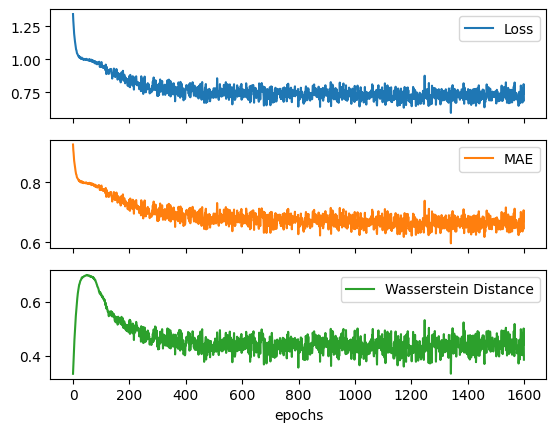

In [291]:
# Convert lists to DataFrame
metrics_df = pd.DataFrame({
    'Loss': losses,
    'MAE': maes,
    'Wasserstein Distance': wasserstein_distances
})

# Plot metrics
metrics_df.plot(subplots=True)
plt.xlabel('epochs')
plt.show()

In [292]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [293]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 300, n_feat).to(device) 

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        # z must have the same mean and variance as the X_train


        # Generate a tensor with elements drawn from a standard normal distribution
        z = torch.randn_like(samples)  if i > 1 else 0


        eps = model(samples,t)    # predict noise e_(x_t,t)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [294]:
# load in model weights and set to eval mode
model.load_state_dict(torch.load(f"{save_dir}/model_9.pth", map_location=device))
model.eval()
print("Loaded in Model")

Loaded in Model


In [295]:
# visualize samples
samples, intermediate_ddpm = sample_ddpm(1)

In [296]:
df_orig = df_orig['Ret'].unstack().T


In [297]:
synth_data = pd.DataFrame(samples[0,:input_size,:].numpy(), index=df_orig[start_year:].index[:input_size], columns=df_orig.columns)

In [298]:
synth_data

Ticker          AAPL       ABT      ADBE       ADI       ADM       ADP  \
date                                                                     
2020-01-02  1.006385  4.928313 -0.274271  1.997813 -1.952157  2.005371   
2020-01-03  2.598788  4.132919  1.187432 -0.423329  0.099961  1.876221   
2020-01-06 -1.720536  1.013557 -1.919774  2.791153 -5.967631 -2.545105   
2020-01-07 -2.417374 -4.140619 -0.807307  0.008791 -4.454224  2.802279   
2020-01-08  0.210704 -5.238436 -3.067870 -0.125307  0.893554  1.356559   
...              ...       ...       ...       ...       ...       ...   
2021-03-05  3.833351  1.716209 -2.006277  0.427129 -1.520655 -0.858734   
2021-03-08  1.781302  3.757916 -2.799320 -2.045818 -0.891106  1.713277   
2021-03-09 -6.009757  1.398195  2.498682  5.131543  2.987075 -0.507017   
2021-03-10 -2.172004 -0.159063  1.277090 -5.163287 -3.741386  1.147387   
2021-03-11  0.344858  0.831216 -3.492819  6.501459  1.464986  3.387257   

Ticker          ADSK       AEE       AEP       AIG  ...       CPB       CSX  \
date                                                ...                       
2020-01-02 -1.857997  1.299630 -1.201811 -6.305106  ...  1.879865  2.591662   
2020-01-03  5.514000 -2.082873  3.687835  2.658880  ...  0.119468 -0.902893   
2020-01-06  5.433540 -1.957380  4.691672  2.771157  ...  2.904833  3.647332   
2020-01-07 -0.262597 -0.550184 -1.019421 -2.225908  ...  3.828095  1.323064   
2020-01-08  0.193848  5.324979  1.584401 -3.711087  ...  4.750440  5.024490   
...              ...       ...       ...       ...  ...       ...       ...   
2021-03-05  3.614259 -0.207881 -0.745204  1.339099  ... -8.110130 -2.810683   
2021-03-08 -0.643746 -4.141203 -1.984059 -2.924503  ...  4.021240  1.996243   
2021-03-09 -1.327348  1.235264 -3.106787 -3.142825  ...  1.570513 -0.092315   
2021-03-10  1.268720  6.213622  5.814111  4.105702  ...  0.698137  0.592007   
2021-03-11 -3.080091  2.737356  1.147034  2.120515  ... -0.410793  3.832110   

Ticker          CTAS       CVX         D        DD       DDS        DE  \
date                                                                     
2020-01-02 -1.977180  0.602952 -2.038366 -0.355707 -5.222956 -2.348956   
2020-01-03 -4.623606  1.307766  0.948520  0.097026  2.802041 -1.332011   
2020-01-06  2.539230  3.083967 -2.281695 -1.954650  0.395122  1.143856   
2020-01-07  0.819950  0.619728  2.331108 -0.886343 -1.693862 -4.706873   
2020-01-08  4.933239 -3.213368  0.410708 -2.143993  5.275929  2.296366   
...              ...       ...       ...       ...       ...       ...   
2021-03-05 -1.262164  1.450570 -4.987395  5.094805  2.443516  4.795882   
2021-03-08 -4.983406 -4.385509  0.425527 -3.954165 -0.292046  1.714993   
2021-03-09  0.097938  0.078489 -2.767293  0.561995  1.031656  2.131216   
2021-03-10 -0.967910  3.309325 -0.562109 -7.533961 -0.436836  0.618636   
2021-03-11 -2.581147  0.816189  5.754225  3.280138 -0.518086 -1.300997   

Ticker           DIS       DOV  
date                            
2020-01-02 -2.187561  0.968538  
2020-01-03  3.524538  4.120545  
2020-01-06  6.726807 -0.079595  
2020-01-07 -1.620516 -2.803381  
2020-01-08 -5.096853 -1.211880  
...              ...       ...  
2021-03-05 -1.407353  0.819869  
2021-03-08  1.939699  1.120011  
2021-03-09 -0.079560  1.616738  
2021-03-10  0.261283 -0.829488  
2021-03-11  3.878559  4.358291  

[300 rows x 53 columns]

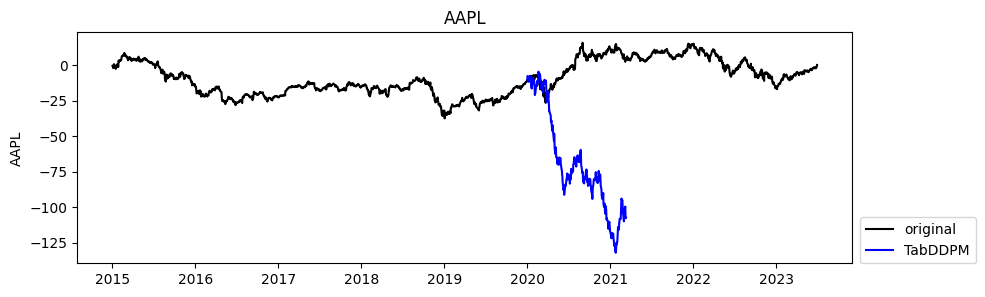

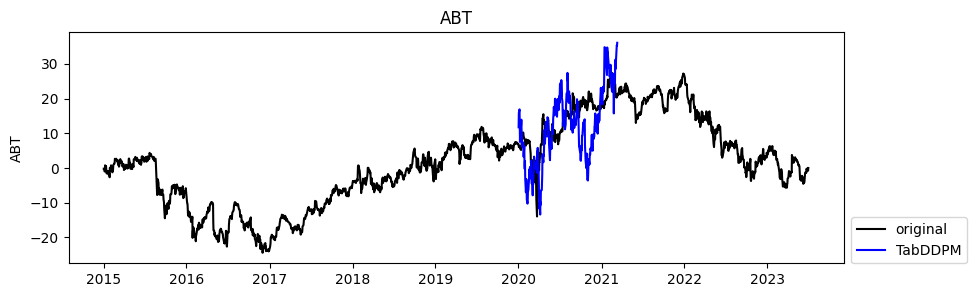

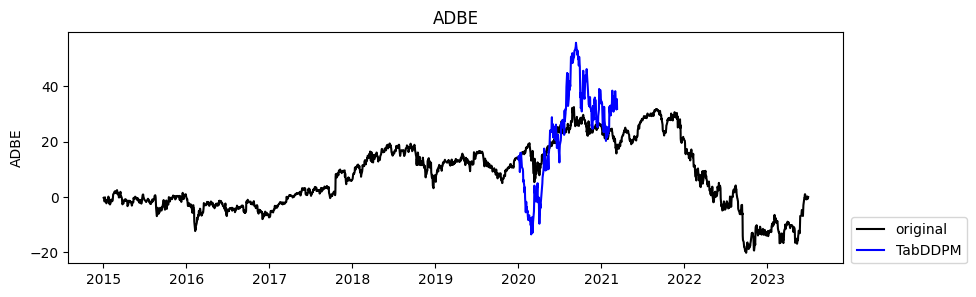

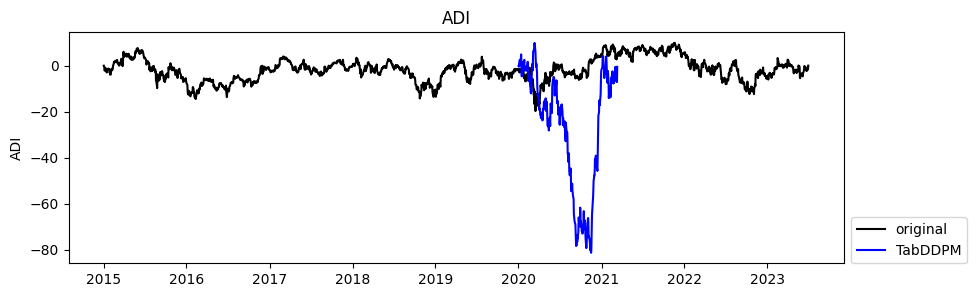

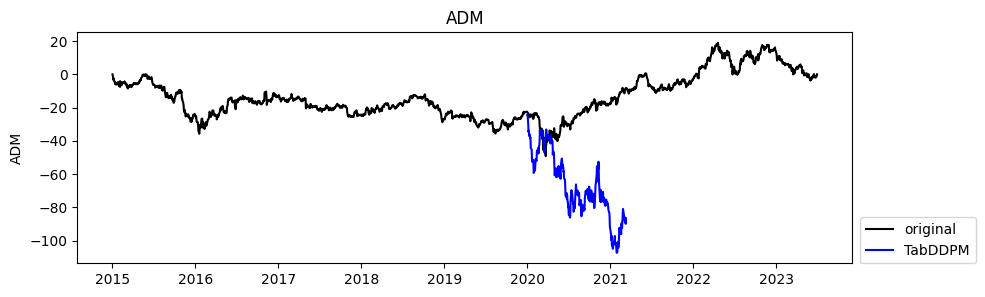

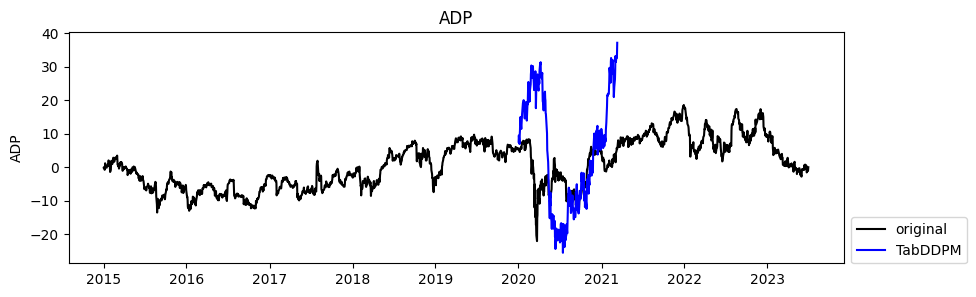

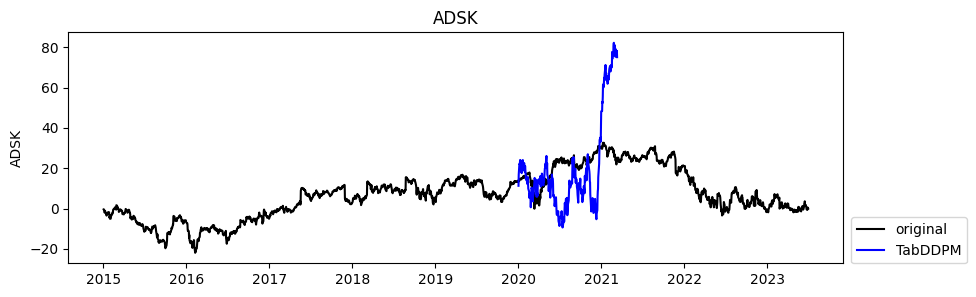

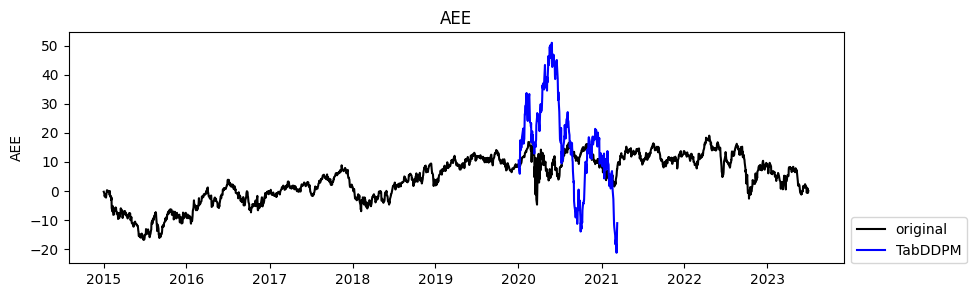

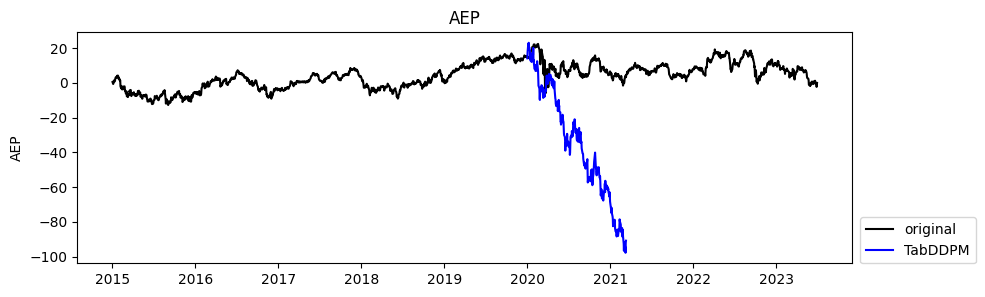

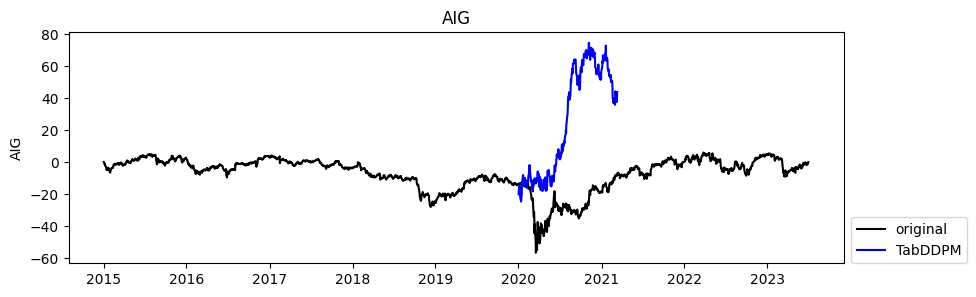

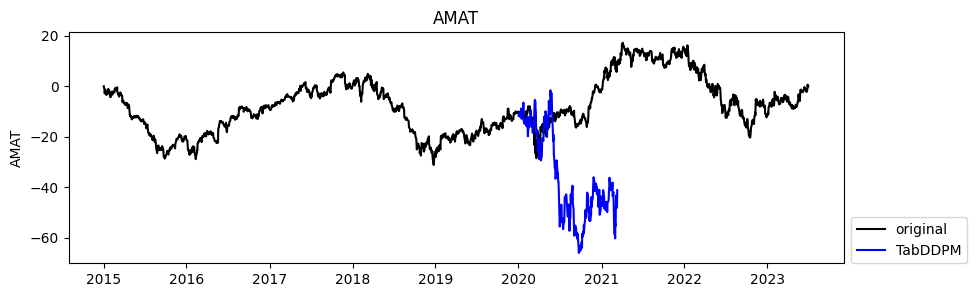

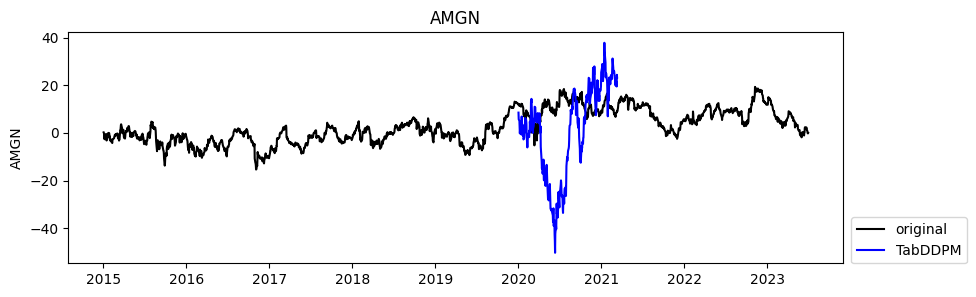

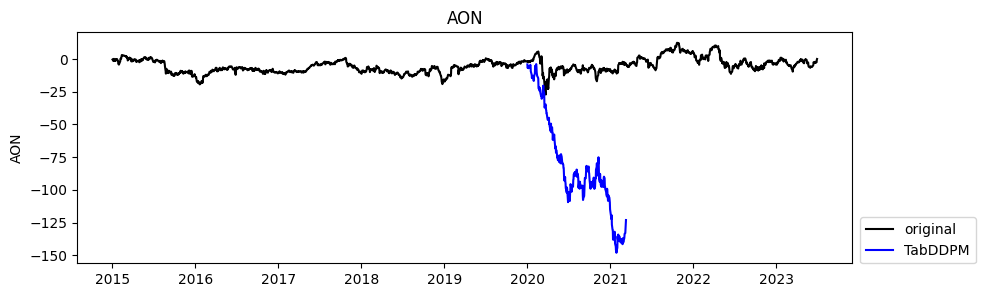

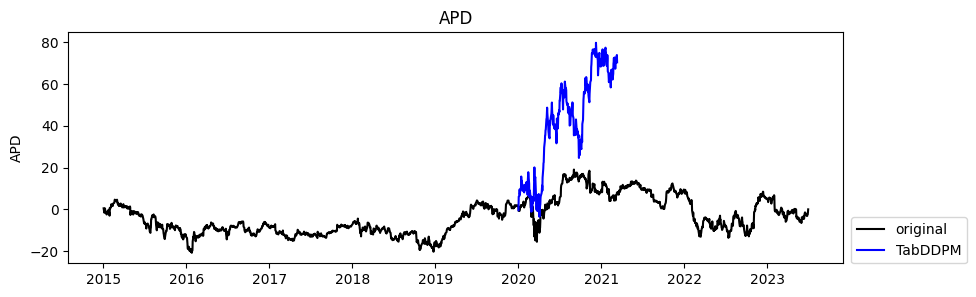

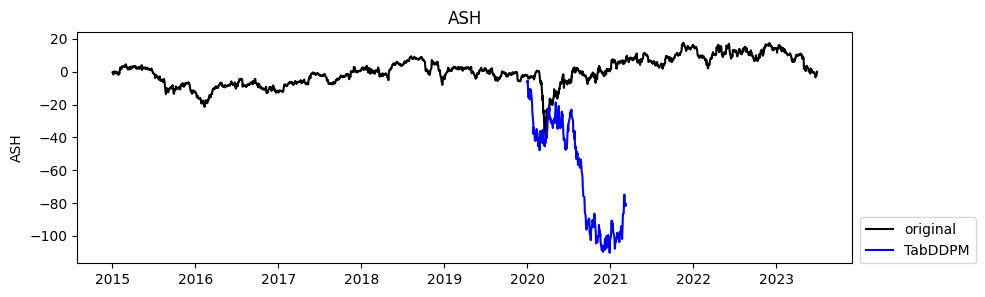

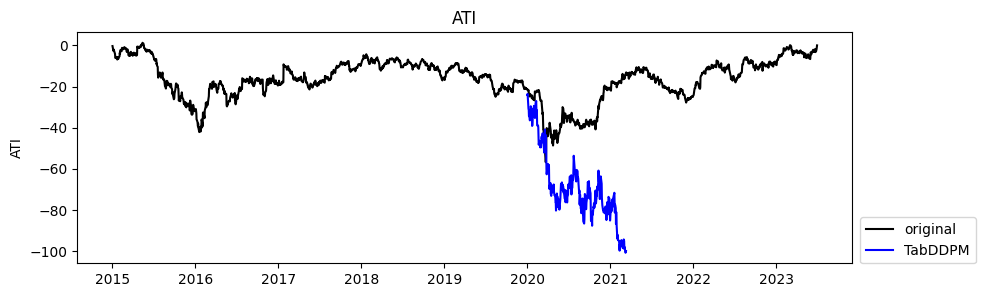

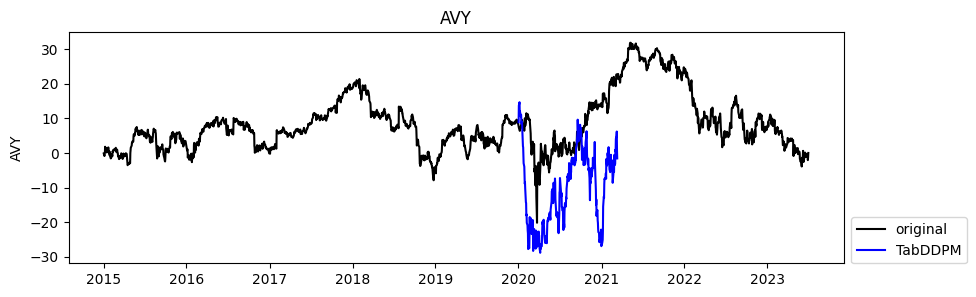

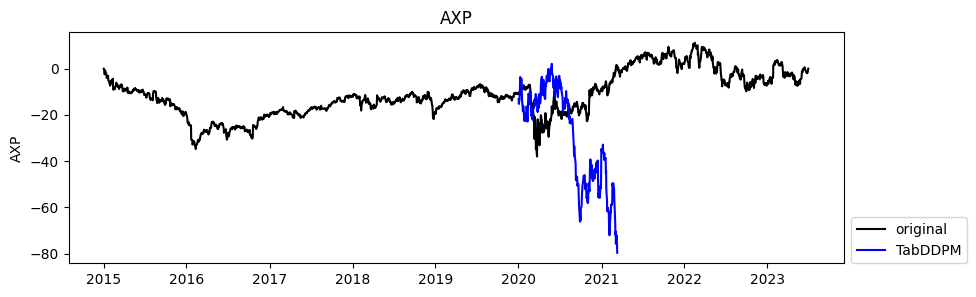

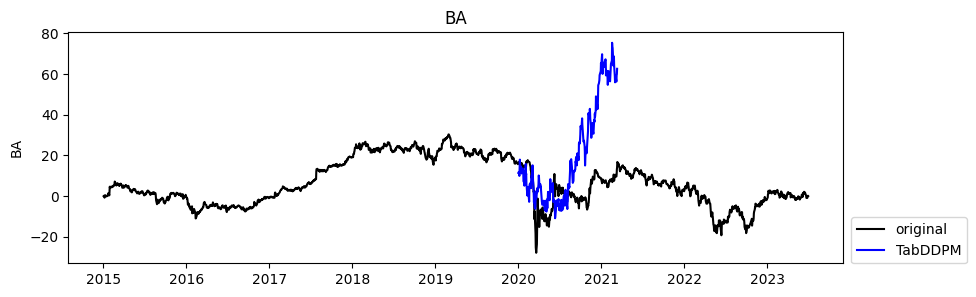

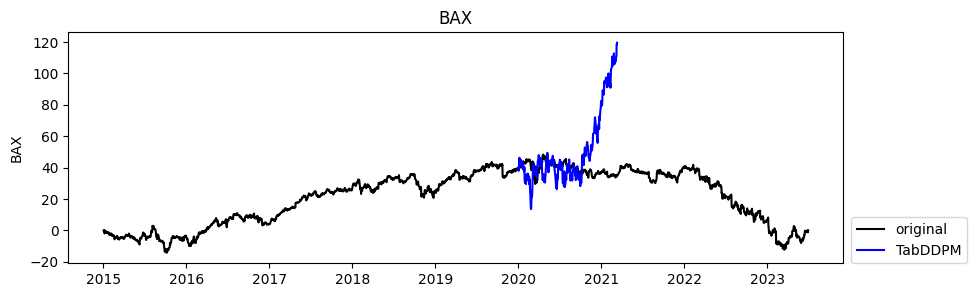

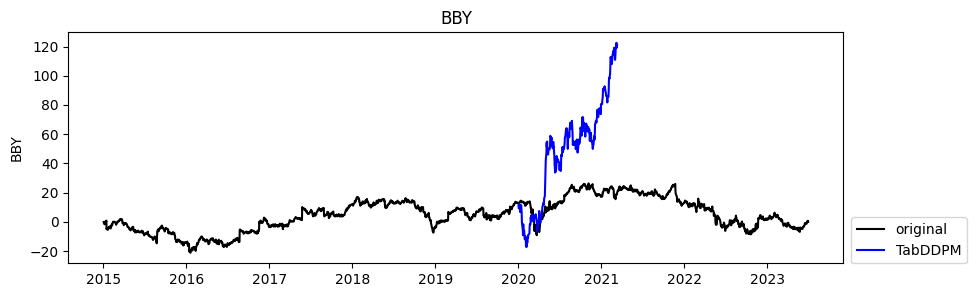

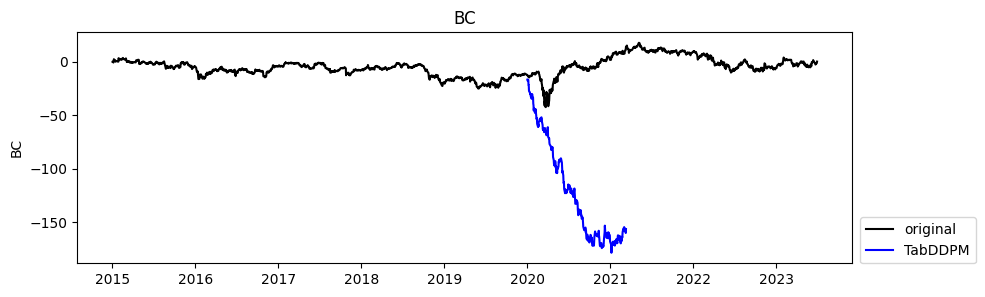

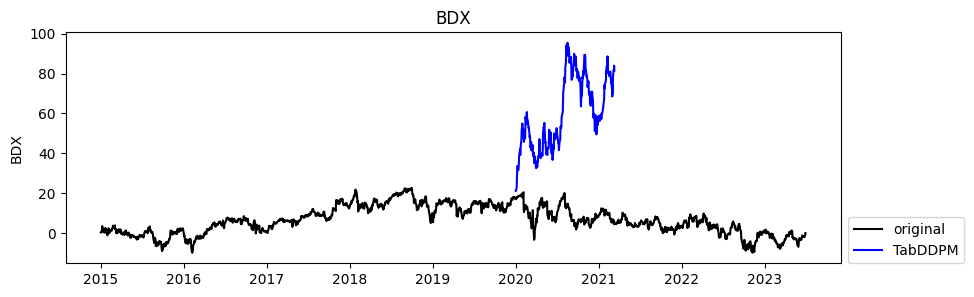

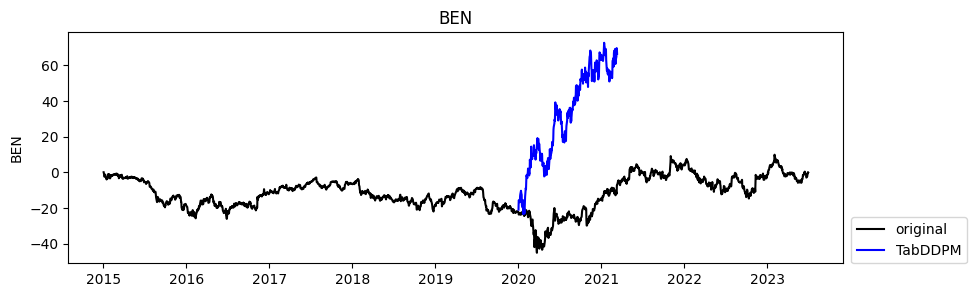

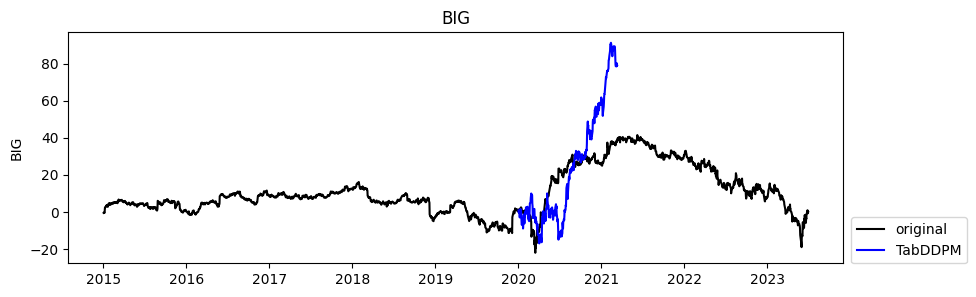

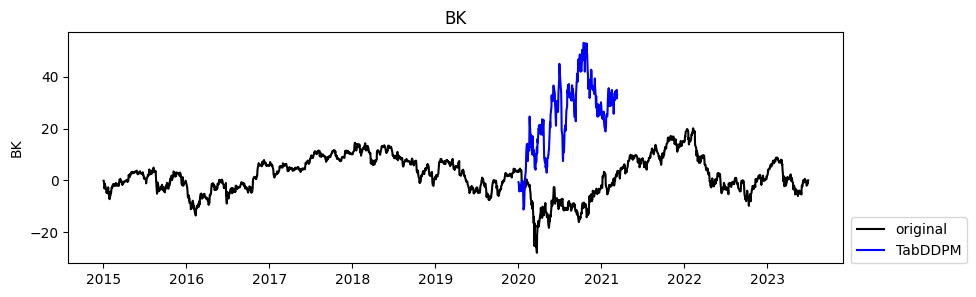

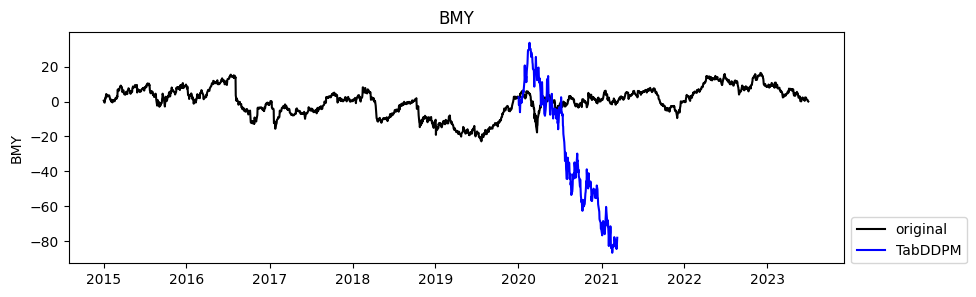

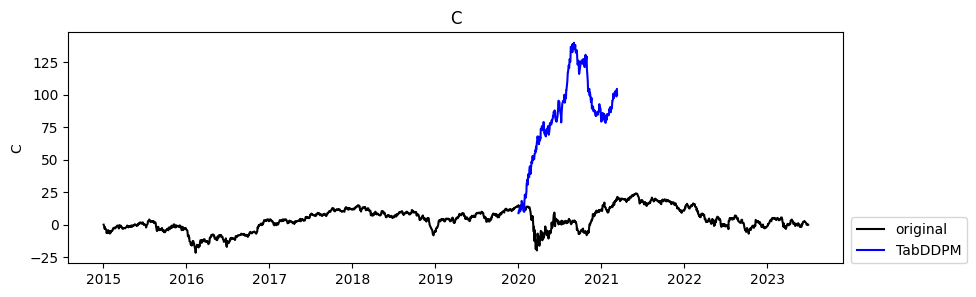

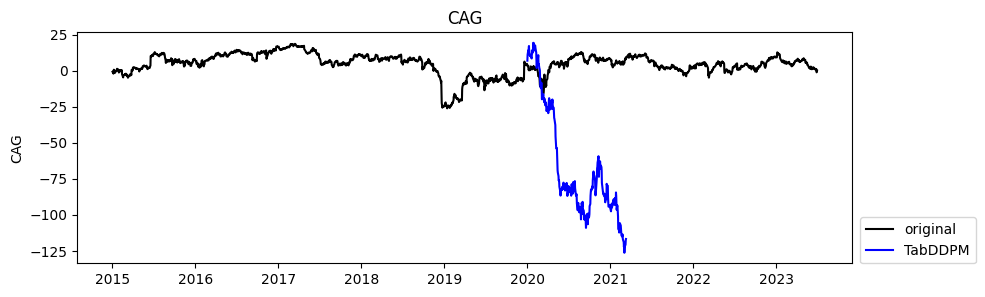

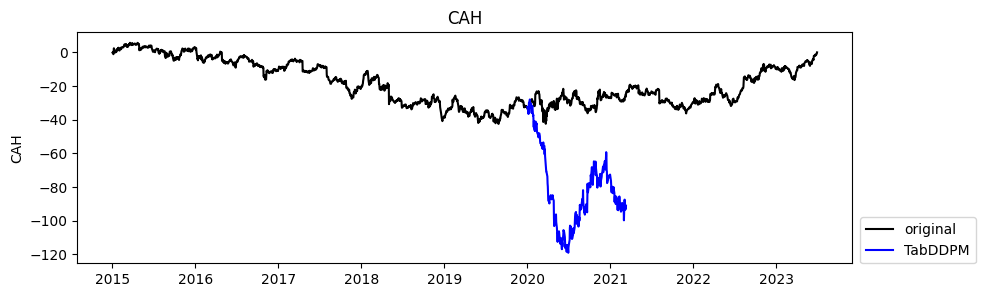

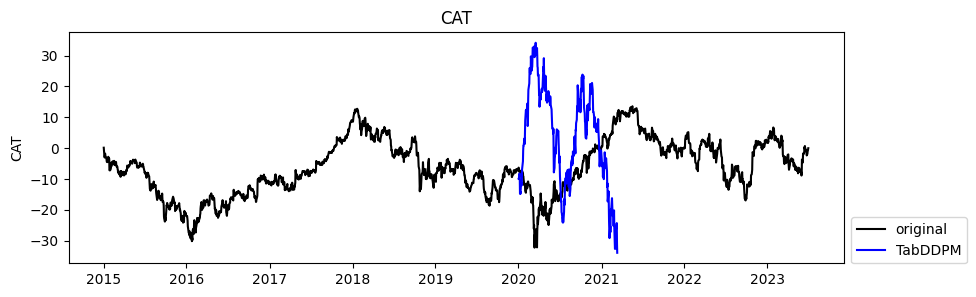

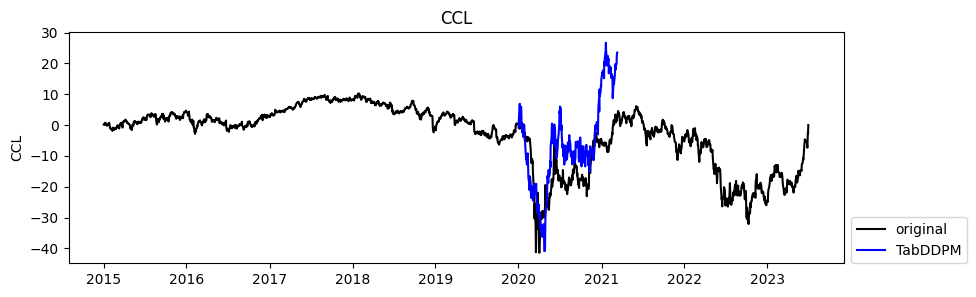

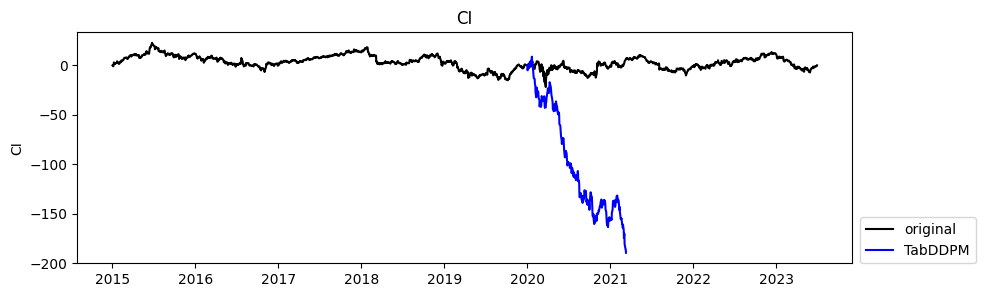

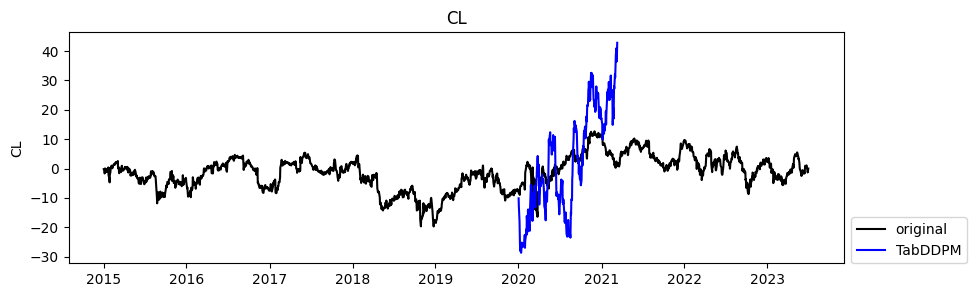

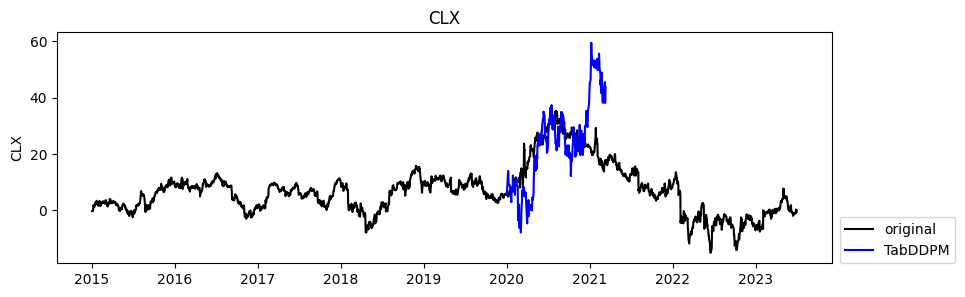

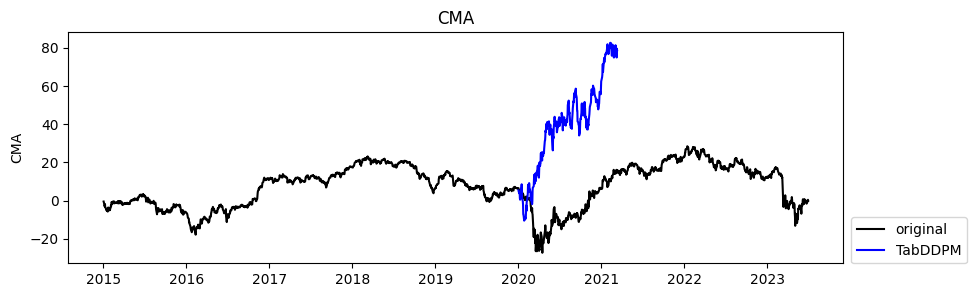

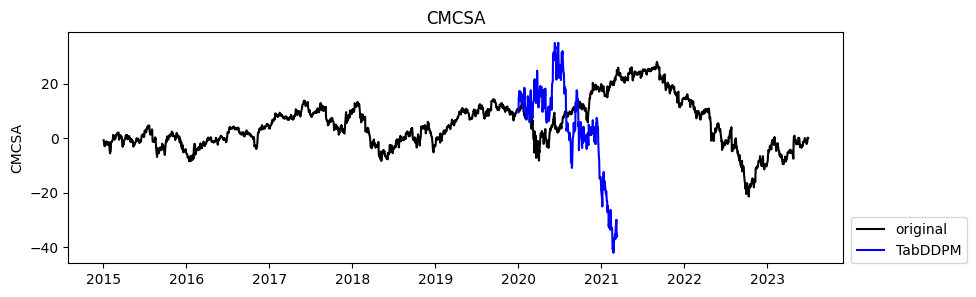

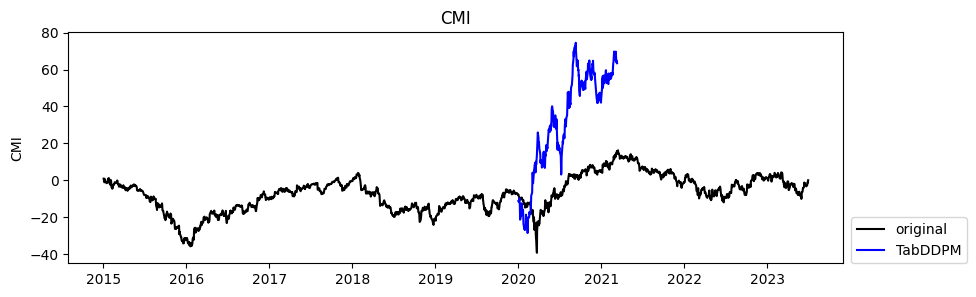

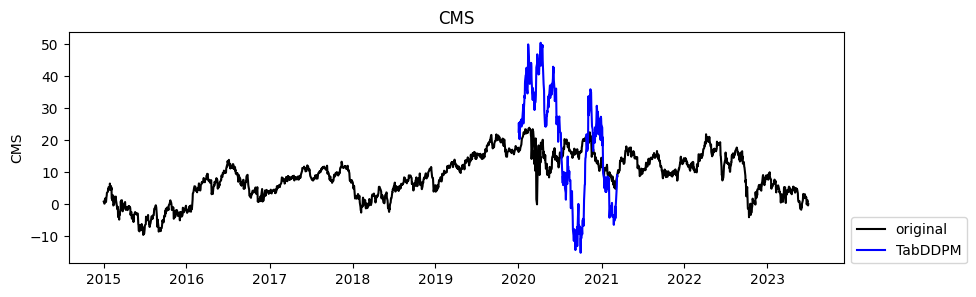

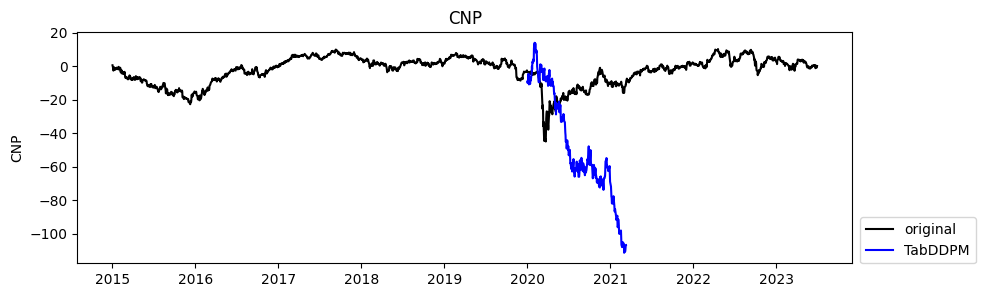

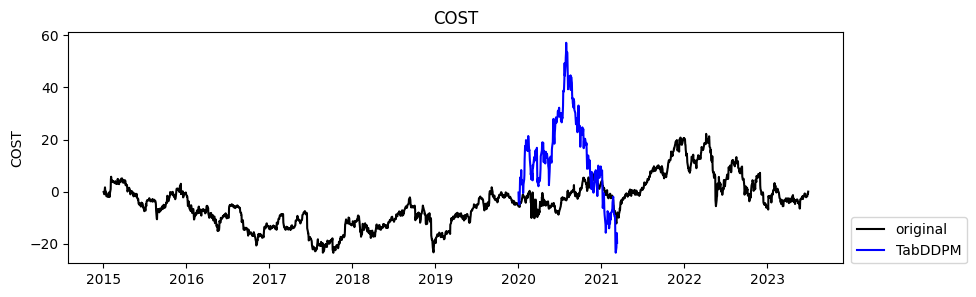

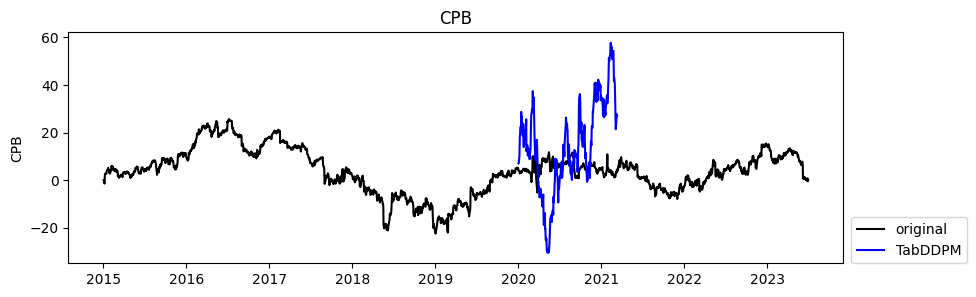

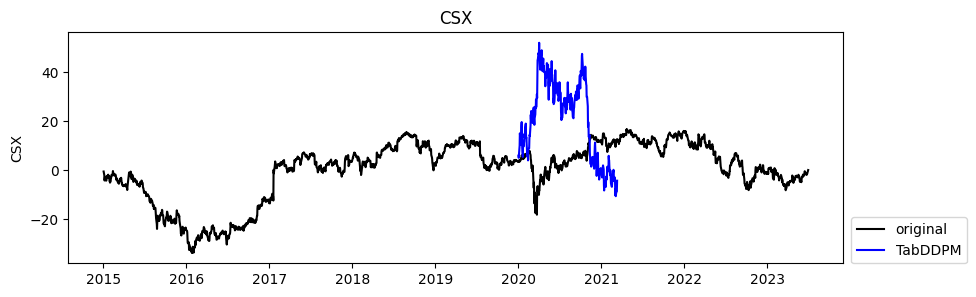

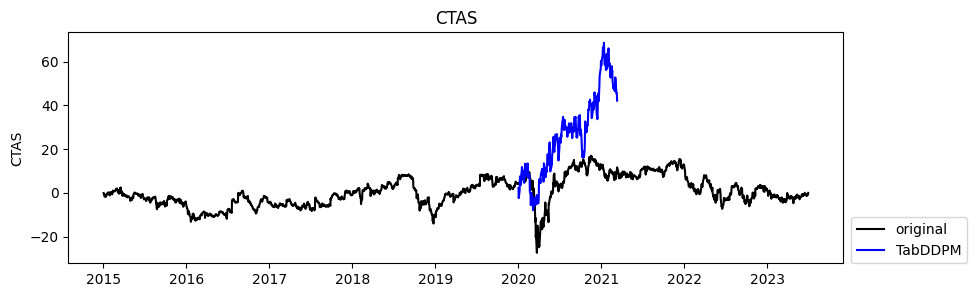

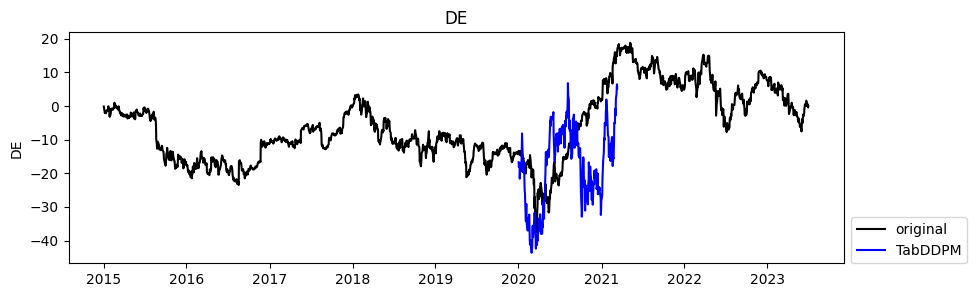

In [299]:
for col in df_orig.columns.tolist():
    starting_point =df[col].cumsum().dropna().iloc[-1]
    values_orig = df_orig[col]
    #get the index of the column col in df
    values_imp = synth_data[col]
    values_orig = values_orig.cumsum()
    values_imp = values_imp.cumsum() + starting_point
    fig, ax = plt.subplots(figsize=(10, 3))
    plt.plot(values_orig, color="black", label="original")

    plt.plot(values_imp, color="blue", label="TabDDPM")
    plt.ylabel(col, fontsize=10)
    plt.legend(loc=[1.01, 0], fontsize=10)
    plt.title(col)
    plt.show()

In [300]:
df['AAPL'].plot()

<Axes: xlabel='date'>

In [301]:
import sdv
import sdv.evaluation.single_table as sdv_st
from sdv.metadata import SingleTableMetadata

true_data = df_orig[df.isna()].dropna()
synthetic_data = synth_data[df.isna()].dropna()

# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=true_data)
# generate quality report
quality_report = sdv_st.evaluate_quality(
    real_data=true_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)


Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 1378/1378 [00:05<00:00, 243.17it/s]

Overall Score: 75.62%

Properties:
- Column Shapes: 72.61%
- Column Pair Trends: 78.64%


In [302]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from scipy.stats import wasserstein_distance
def row_fidelity(synthetic_df, true_df):
    # Assuming a simple row fidelity calculation: Mean absolute difference per row
    return np.mean(np.abs(synthetic_df - true_df), axis=1)

def column_fidelity(synthetic_df, true_df):
    # Assuming column fidelity as the comparison of mean values per column
    fidelity_scores = {}
    for col in synthetic_df.columns:
        fidelity_scores[col] = np.mean(np.abs(synthetic_df[col] - true_df[col]))
    return fidelity_scores

def kl_divergence_columns(synthetic_df, true_df, epsilon=1e-12):
    """
    Compute the KL divergence between each corresponding column of the synthetic and true dataframes.
    epsilon is used to avoid division by zero.
    """
    kl_scores = pd.DataFrame(index = synthetic_df.columns.tolist(),columns = ['KL divergence col'])
    for col in synthetic_df.columns:
        # Ensuring the data is in the form of a distribution
        synthetic_dist = np.histogram(synthetic_df[col], bins=10, density=True)[0]
        true_dist = np.histogram(true_df[col], bins=10, density=True)[0]
        
        # Adding epsilon to avoid division by zero or log of zero
        synthetic_dist += epsilon
        true_dist += epsilon
        
        kl_div = entropy(true_dist, synthetic_dist)
        kl_scores.loc[col,'KL divergence col'] = kl_div
        
    return kl_scores


def kl_divergence_rows(synthetic_df, true_df, epsilon=1e-12):
    """
    Compute the KL divergence between each corresponding column of the synthetic and true dataframes.
    epsilon is used to avoid division by zero.
    """
    kl_scores = pd.DataFrame(index = synthetic_df.index.tolist(),columns = ['KL divergence rows'])
    for date in synthetic_df.index.tolist():
        # Ensuring the data is in the form of a distribution
        synthetic_dist = np.histogram(synthetic_df.loc[date], bins=10, density=True)[0]
        true_dist = np.histogram(true_df.loc[date], bins=10, density=True)[0]
        
        # Adding epsilon to avoid division by zero or log of zero
        synthetic_dist += epsilon
        true_dist += epsilon
        
        kl_div = entropy(true_dist, synthetic_dist)
        kl_scores.loc[date,'KL divergence rows'] = kl_div
        
    return kl_scores

def wasserstein_distance_columns(synthetic_df, true_df):
    """
    Compute the Wasserstein distance between each corresponding column of the synthetic and true dataframes.
    """
    wasserstein_scores = pd.DataFrame(index = synthetic_df.columns.tolist(),columns = ['Wassertstein distance col'])
    for col in synthetic_df.columns.tolist():
        ws_dist = wasserstein_distance(synthetic_data[col],true_df[col])
        wasserstein_scores.loc[col,'Wassertstein distance col'] = ws_dist
        
    return wasserstein_scores

def wasserstein_distance_rows(synthetic_df, true_df):
    """
    Compute the Wasserstein distance between each corresponding column of the synthetic and true dataframes.
    """
    wasserstein_scores = pd.DataFrame(index = synthetic_df.index.tolist(),columns = ['Wassertstein distance rows'])
    for date in synthetic_df.index.tolist():
        ws_dist = wasserstein_distance(synthetic_data.loc[date],true_df.loc[date])
        wasserstein_scores.loc[date,'Wassertstein distance rows'] = ws_dist        
    return wasserstein_scores

kl_col = kl_divergence_columns(synthetic_data,true_data)
kl_rows = kl_divergence_rows(synthetic_data,true_data)
wasserstein_col = wasserstein_distance_columns(synthetic_data,true_data)
wasserstein_rows = wasserstein_distance_rows(synthetic_data,true_data)


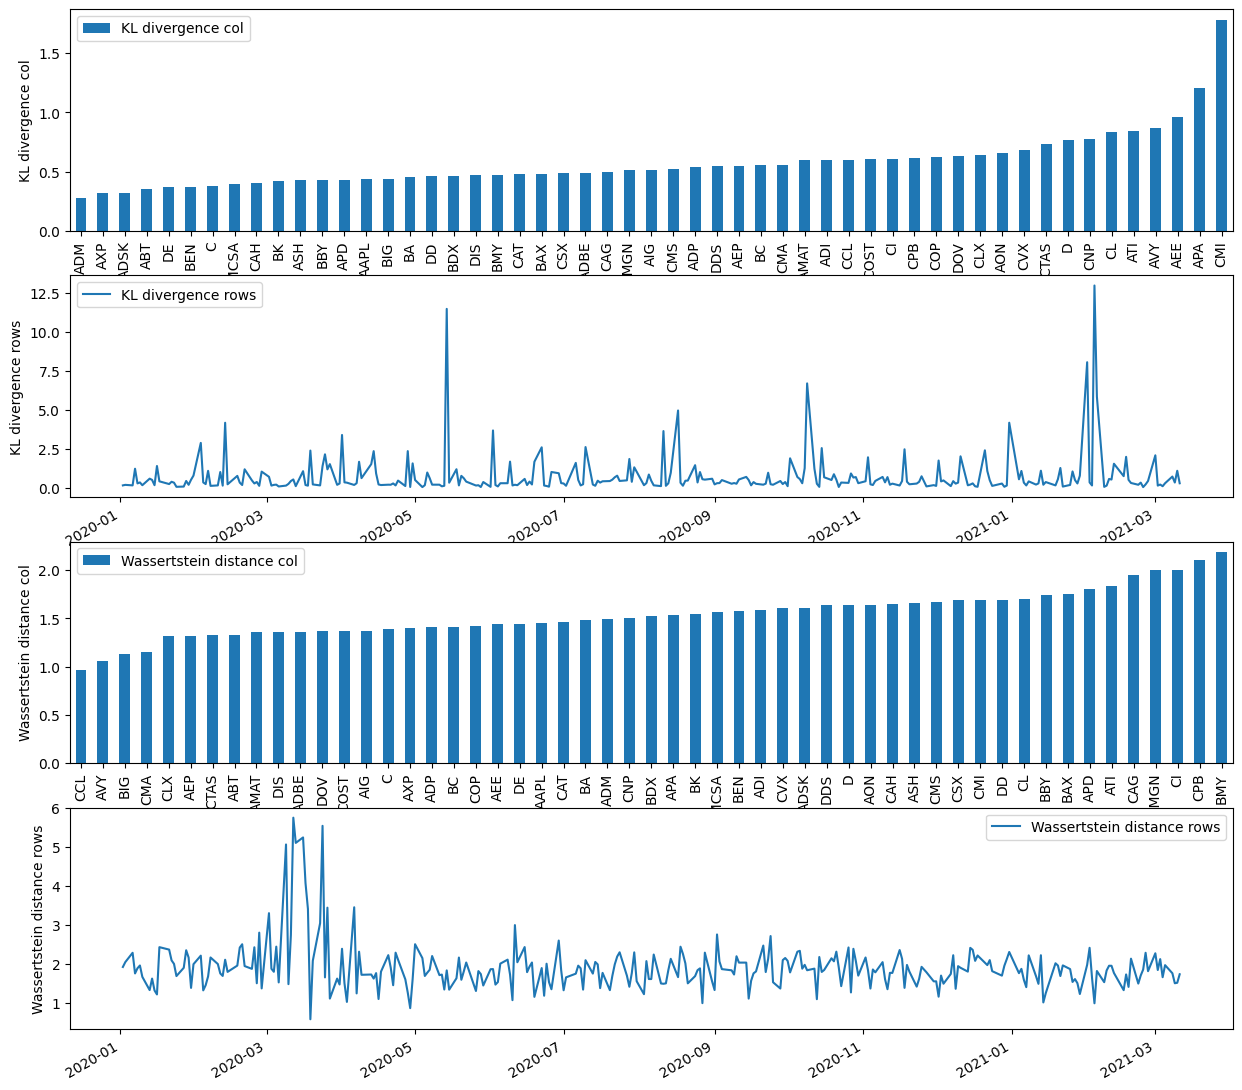

In [303]:

fig,axes = plt.subplots(nrows=4,ncols = 1,figsize = (15,15))
metrics = [kl_col,kl_rows,wasserstein_col, wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)


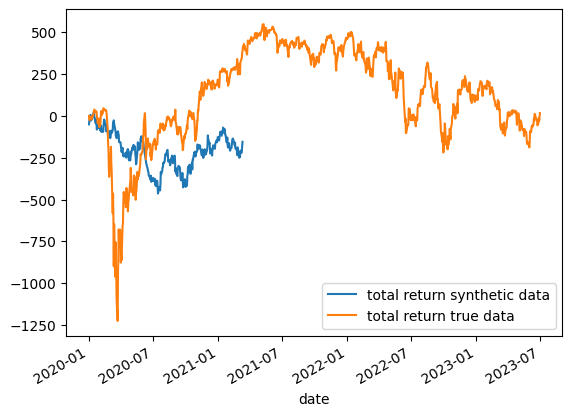

In [304]:
synthetic_data.cumsum().sum(1).plot(label = 'total return synthetic data')
true_data.cumsum().sum(1).plot(label = 'total return true data')
plt.legend()

Frobenius Norm: 79.35351262980964
Spectral Norm: 25.773572972838245
Condition Number - True Data: 299.3911090299096
Condition Number - Synthetic Data: 77.3578031712844


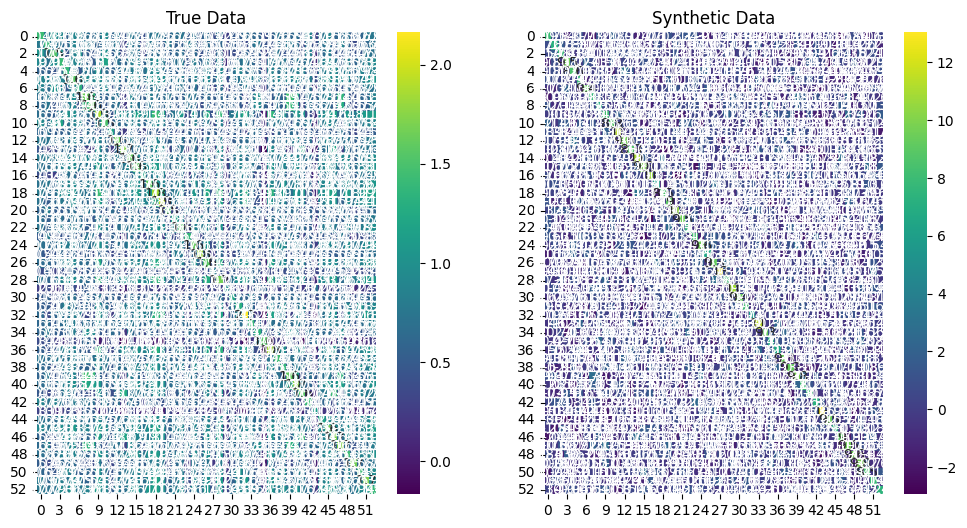

In [305]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_frobenius_norm(matrix1, matrix2):
    return np.linalg.norm(matrix1 - matrix2, 'fro')

def compute_spectral_norm(matrix1, matrix2):
    return np.linalg.norm(matrix1 - matrix2, 2)

def compute_condition_number(matrix):
    return np.linalg.cond(matrix)

def plot_covariance_matrices(cov_matrix_true, cov_matrix_synthetic, titles=['True Data', 'Synthetic Data']):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    sns.heatmap(cov_matrix_true, ax=axs[0], cmap='viridis', annot=True)
    axs[0].set_title(titles[0])

    sns.heatmap(cov_matrix_synthetic, ax=axs[1], cmap='viridis', annot=True)
    axs[1].set_title(titles[1])

    plt.show()

cov_matrix_true = np.cov(true_data, rowvar=False)
cov_matrix_synthetic = np.cov(synthetic_data, rowvar=False)


# Calculate metrics
frobenius_norm = compute_frobenius_norm(cov_matrix_true, cov_matrix_synthetic)
spectral_norm = compute_spectral_norm(cov_matrix_true, cov_matrix_synthetic)
condition_number_true = compute_condition_number(cov_matrix_true)
condition_number_synthetic = compute_condition_number(cov_matrix_synthetic)

# Print metrics
print(f"Frobenius Norm: {frobenius_norm}")
print(f"Spectral Norm: {spectral_norm}")
print(f"Condition Number - True Data: {condition_number_true}")
print(f"Condition Number - Synthetic Data: {condition_number_synthetic}")

# Plot covariance matrices
plot_covariance_matrices(cov_matrix_true, cov_matrix_synthetic)


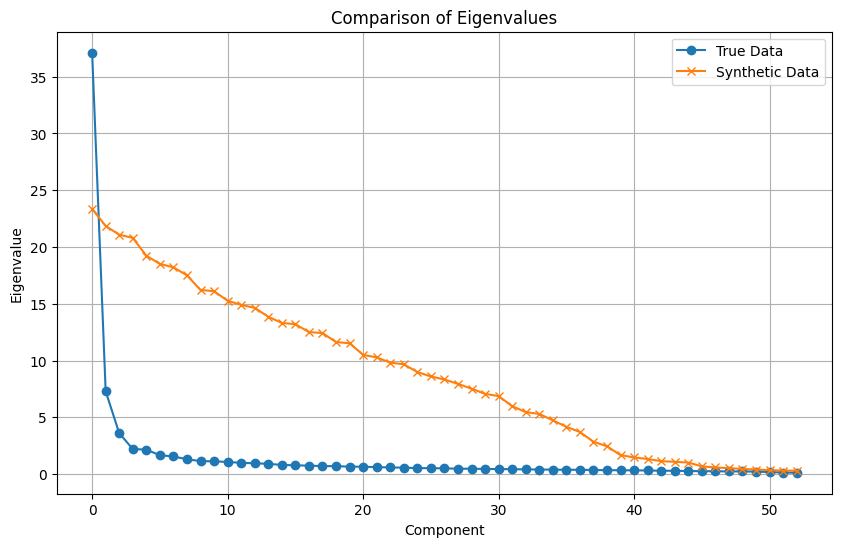

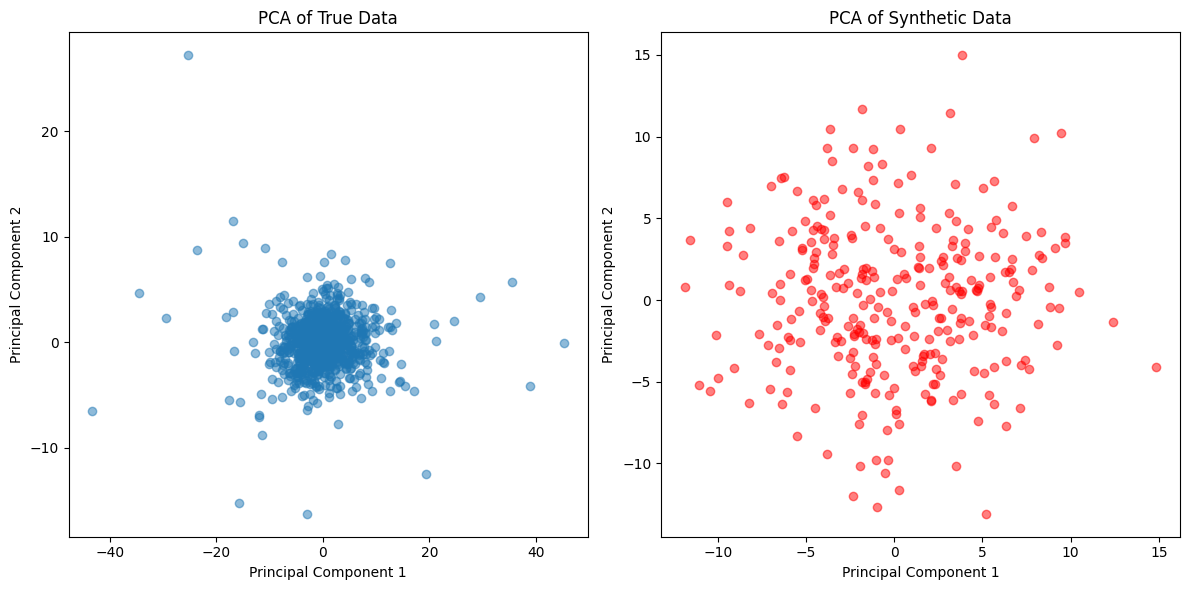

In [306]:
import numpy as np
import matplotlib.pyplot as plt

def eigen_decomposition(cov_matrix):
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # Sort the eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    return eigenvalues, eigenvectors

def plot_eigenvalues(eigenvalues_true, eigenvalues_synthetic):
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvalues_true, label='True Data', marker='o')
    plt.plot(eigenvalues_synthetic, label='Synthetic Data', marker='x')
    plt.ylabel('Eigenvalue')
    plt.xlabel('Component')
    plt.title('Comparison of Eigenvalues')
    plt.legend()
    plt.grid(True)
    plt.show()

def pca_visualization(data_true, data_synthetic, n_components=2):
    from sklearn.decomposition import PCA
    pca_true = PCA(n_components=n_components).fit_transform(data_true)
    pca_synthetic = PCA(n_components=n_components).fit_transform(data_synthetic)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(pca_true[:, 0], pca_true[:, 1], alpha=0.5, label='True Data')
    plt.title('PCA of True Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.subplot(1, 2, 2)
    plt.scatter(pca_synthetic[:, 0], pca_synthetic[:, 1], alpha=0.5, label='Synthetic Data', color='r')
    plt.title('PCA of Synthetic Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    plt.tight_layout()
    plt.show()


# Eigenvalue decomposition
eigenvalues_true, eigenvectors_true = eigen_decomposition(cov_matrix_true)
eigenvalues_synthetic, eigenvectors_synthetic = eigen_decomposition(cov_matrix_synthetic)

# Plot eigenvalues
plot_eigenvalues(eigenvalues_true, eigenvalues_synthetic)

# PCA visualization (assuming the original data matrices are stored in `true_data` and `synthetic_data`)
pca_visualization(true_data, synthetic_data)


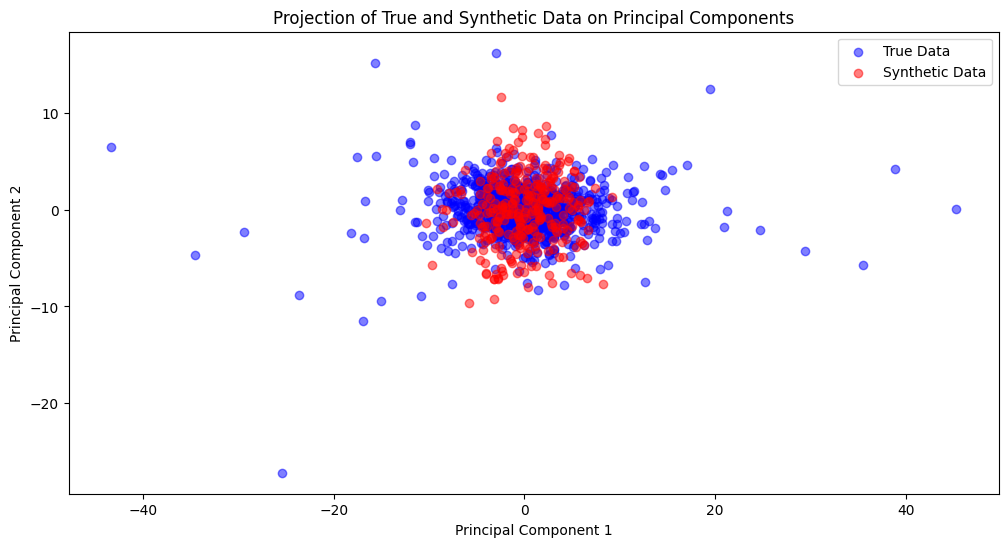

In [307]:
import numpy as np
import matplotlib.pyplot as plt

def compute_principal_components(data):
    # Center the data
    data_meaned = data - np.mean(data, axis=0)
    # Compute covariance matrix
    covariance_matrix = np.cov(data_meaned, rowvar=False)
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    return eigenvalues, eigenvectors

def project_onto_principal_components(data, eigenvectors):
    # Center the data
    data_meaned = data - np.mean(data, axis=0)
    # Project data
    return np.dot(data_meaned, eigenvectors)

def plot_projection_on_principal_components(projection_true, projection_synthetic):
    plt.figure(figsize=(12, 6))
    
    # Assuming we're interested in the first two principal components for visualization
    plt.scatter(projection_true[:, 0], projection_true[:, 1], alpha=0.5, label='True Data', color='blue')
    plt.scatter(projection_synthetic[:, 0], projection_synthetic[:, 1], alpha=0.5, label='Synthetic Data', color='red')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.title('Projection of True and Synthetic Data on Principal Components')
    plt.show()


# Compute principal components from true data
_, eigenvectors_true = compute_principal_components(true_data)

# Project both true and synthetic data onto these principal components
projection_true = project_onto_principal_components(true_data, eigenvectors_true)
projection_synthetic = project_onto_principal_components(synthetic_data, eigenvectors_true)

# Visualize the projections
plot_projection_on_principal_components(projection_true, projection_synthetic)


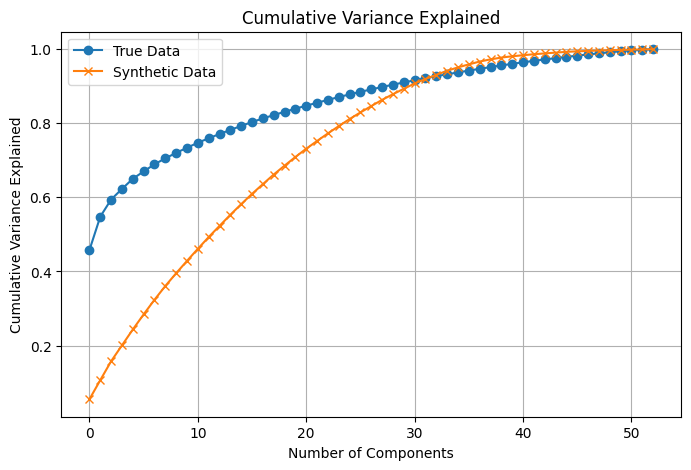

In [308]:
def plot_cumulative_variance(eigenvalues_true, eigenvalues_synthetic, title='Cumulative Variance Explained'):
    # Compute cumulative variance explained
    cumulative_variance_true = np.cumsum(eigenvalues_true) / np.sum(eigenvalues_true)
    cumulative_variance_synthetic = np.cumsum(eigenvalues_synthetic) / np.sum(eigenvalues_synthetic)

    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance_true, label='True Data', marker='o')
    plt.plot(cumulative_variance_synthetic, label='Synthetic Data', marker='x')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


def biplot(score, loadings, labels=None, title="Biplot", points_label=None, axis_labels=('PC1', 'PC2')):
    plt.figure(figsize=(10, 7))
    xs = score[:,0]
    ys = score[:,1]
    n = loadings.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, c='gray') # Plot points
    if points_label is not None:
        for i, txt in enumerate(points_label):
            plt.annotate(txt, (xs[i] * scalex, ys[i] * scaley), textcoords="offset points", xytext=(0,10), ha='center')
    for i in range(n):
        # Plot arrows
        plt.arrow(0, 0, loadings[i,0], loadings[i,1], color='r', alpha=0.5)
        if labels is not None:
            plt.text(loadings[i,0]* 1.15, loadings[i,1] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlabel(axis_labels[0])
    plt.ylabel(axis_labels[1])
    plt.title(title)
    plt.grid(True)
    plt.show()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming `true_data` and `synthetic_data` are your datasets
# Standardize the data
scaler = StandardScaler()
true_data_scaled = scaler.fit_transform(true_data)
synthetic_data_scaled = scaler.transform(synthetic_data)  # Use the same scaler

# Perform PCA
pca_true = PCA()
pca_synthetic = PCA()
true_scores = pca_true.fit_transform(true_data_scaled)
synthetic_scores = pca_synthetic.fit_transform(synthetic_data_scaled)

# Eigenvalues (explained variance)
eigenvalues_true = pca_true.explained_variance_
eigenvalues_synthetic = pca_synthetic.explained_variance_

plot_cumulative_variance(eigenvalues_true, eigenvalues_synthetic)
